In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, y_train = x_train[:30000], y_train[:30000]
x_valid, y_valid = x_test[:3000], y_test[:3000]
x_test, y_test = x_test[3000:], y_test[3000:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0
x_valid = x_valid / 255.0

tr_pairs, tr_y = create_pairs_on_set(x_train, y_train)
tv_pairs, tv_y = create_pairs_on_set(x_valid, y_valid)
ts_pairs, ts_y = create_pairs_on_set(x_test, y_test)

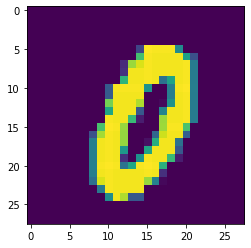

In [5]:
from matplotlib import pyplot as plt

plt.imshow(tr_pairs[2][1])
plt.show()

In [6]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

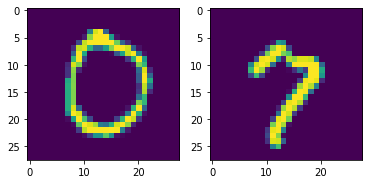

0.0


In [7]:
def show_image_pairs(image_pair):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_pair[0])
#     ax.colorbar()
    ax[0].grid(False)
    ax[1].imshow(image_pair[1])
#     ax[1].colorbar()
    ax[1].grid(False)
    
    plt.show()

this_pair = 9

show_image_pairs(ts_pairs[this_pair])
print(ts_y[this_pair])

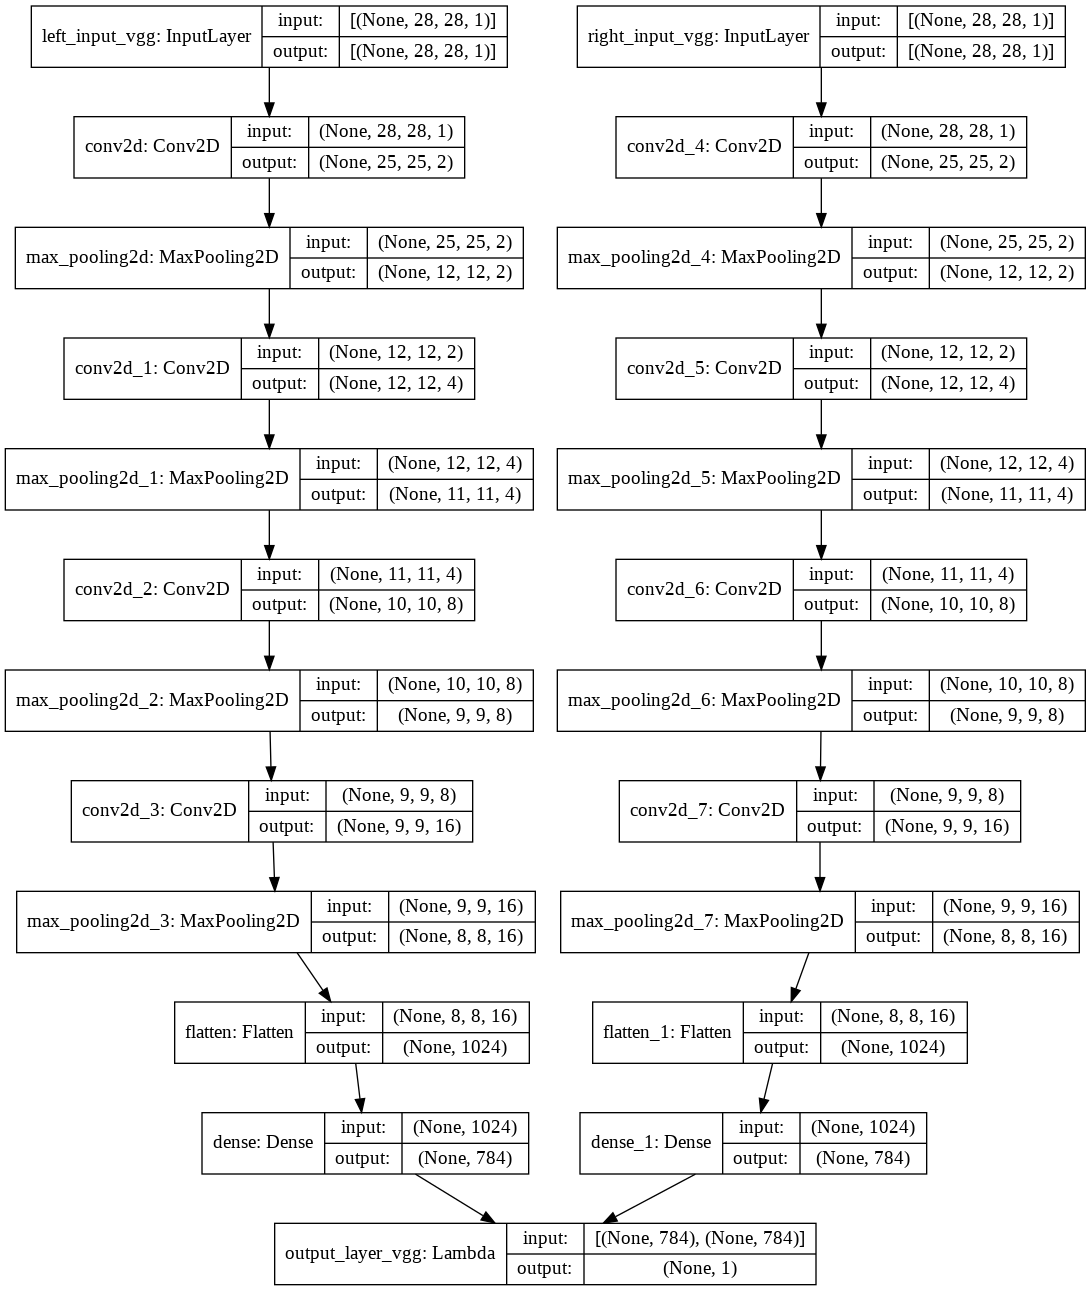

In [8]:
def short_vgg(input_layer):
    in_vgg = input_layer
    div = 32

    x = Conv2D(input_shape=(28,28,1),filters=64//div,kernel_size=((4,4)),padding="valid", activation="relu")(in_vgg)

#     x = Conv2D(filters=64//div,kernel_size=((2,2)),padding="valid", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x = Conv2D(filters=128//div, kernel_size=((1,1)), padding="same", activation="relu")(x)

#     x = Conv2D(filters=128//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Conv2D(filters=256//div, kernel_size=((2,2)), padding="valid", activation="relu")(x)

    #     x = Conv2D(filters=256//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
#     x = Conv2D(filters=256//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Conv2D(filters=512//div, kernel_size=((2,2)), padding="same", activation="relu")(x)

    #     x = Conv2D(filters=512//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
#     x = Conv2D(filters=512//16, kernel_size=((1,1)), padding="same", activation="relu")(x)

    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Flatten()(x)
    x = Dense(28*28)(x)

    return x

input_a_vgg = Input(shape=(28,28,1), name="left_input_vgg")
vect_output_a_vgg = short_vgg(input_a_vgg)

input_b_vgg = Input(shape=(28,28,1), name="right_input_vgg")
vect_output_b_vgg = short_vgg(input_b_vgg)

output_vgg = Lambda(euclidean_distance, name="output_layer_vgg", output_shape=eucl_dist_output_shape)([vect_output_a_vgg, vect_output_b_vgg])

model_vgg = Model([input_a_vgg, input_b_vgg], output_vgg)

plot_model(model_vgg, show_shapes=True, show_layer_names=True, to_file='outer-siamese-model_vgg.png')

In [9]:
def scheduler(epoch, lr):
  if (epoch % 15) == 0:
    return lr * 0.8
  else:
    return lr
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss


es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

adam = keras.optimizers.Adam(learning_rate=0.001)
rms = keras.optimizers.RMSprop()

model_vgg.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=adam)
history = model_vgg.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=50, batch_size=512, validation_data=([tv_pairs[:,0], tv_pairs[:,1]], tv_y),
                       callbacks=[lrs, es], verbose=1)

n_epochs = len(history.history['loss'])

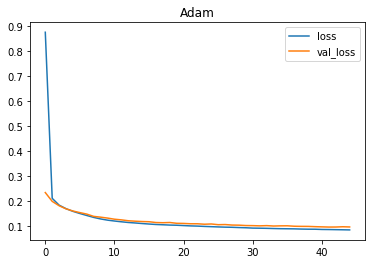

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Adam')
plt.legend()
plt.show()

In [13]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


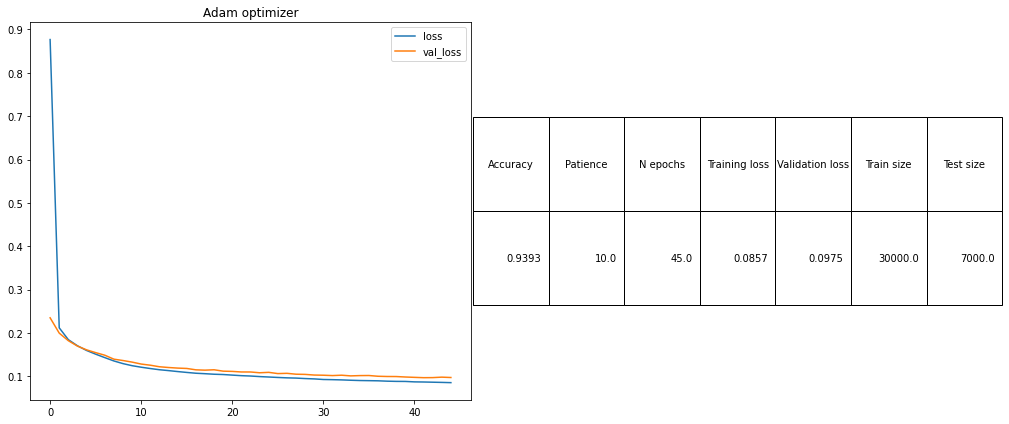

In [15]:
import pandas as pd

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title('Adam optimizer')
results_predict = model_vgg.predict([ts_pairs[:,0], ts_pairs[:,1]])
acc = compute_accuracy(ts_y, results_predict)
dfxx = pd.DataFrame(columns=['Accuracy', 'Patience', 'N epochs', 'Training loss', 'Validation loss', 'Train size', 'Test size'], index=[1],
                    data=np.array([np.around(acc, 4), 10, n_epochs, np.around(history.history['loss'][-1], 4), 
                                   np.around(history.history['val_loss'][-1], 4), int(x_train.shape[0]), int(x_test.shape[0])]).reshape(-1,1).T)

ax2 = fig.add_subplot(122)
font_size=10
bbox=[-0.1, 0.25, 1.2, 0.5]
ax2.axis('off')
mpl_table = ax2.table(cellText = dfxx.values, rowLabels = [''], bbox=bbox, colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
# plt.show()
plt.tight_layout()
plt.savefig('table_vgg_adam_1.png', dpi=200)
print()

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
num_classes = 10
confusion_matrix = np.zeros((num_classes, num_classes))
all_images = []
already = [0]
for i in range(30):
  if y_train[i] == already[-1] and len(all_images)<10:
    all_images.append(np.expand_dims(x_train[i], 0))
    already.append(y_train[i]+1)
dict_matrix = {str(x):0 for x in range(10)}


In [17]:

def checkYPred(to_check):
  highest = np.inf
  y_pred = -1
  for i, img in enumerate(all_images):
    res_pred = model_vgg.predict([np.expand_dims(to_check, 0), img])
    if res_pred[0][0] < highest:
      highest = res_pred[0][0]
      y_pred = i
  return y_pred


# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = x_train[np.where(y_train==class_idx)][:10]
    for y_test_idx in example_idxs:
        count_mis = 0
        # And count the classes of its near neighbours.
        y_pred = checkYPred(y_test_idx)
        if class_idx == y_pred:
          confusion_matrix[class_idx, y_pred] += 1
        elif (count_mis % 5) == 0:
          count_mis += 1
          confusion_matrix[class_idx, y_pred] += 1



<Figure size 2160x2160 with 0 Axes>

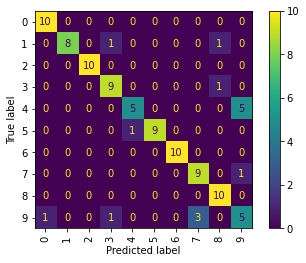

In [18]:
# Display a confusion matrix.
plt.figure(figsize=(30,30))
labels = [str(x) for x in range(10)]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.savefig('conf_matrix_snn_vgg.png')
plt.show()


### X_train shape: 20.000
### X_test shape: 3.000
### Patience: 3
#### Adam optimizer: 0.9475925925925925
#### RMSProp: 0.9466666666666667

### Patience: 5
#### Adam optimizer: 0.9511111111111111
#### RMSProp: 0.9507407407407408

